# CDS513 Project_Time Series Analysis

In [1]:
# Import necessary libraries 
import os
import warnings
import pandas as pd
import seaborn as sns
sns.set()
import pandas as pd
from datetime import *
from pandas import concat
import statsmodels.api as sm
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
warnings.filterwarnings('ignore')

In [2]:
# Read the data
files = [file for file in os.listdir('E:/DS/DS material Sem 3/513/Project/Dataset')]
Merged = pd.DataFrame()

In [3]:
# Merge the data
for file in files:
    df = pd.read_csv('E:/DS/DS material Sem 3/513/Project/Dataset/'+file)
    Merged = pd.concat([Merged, df])

In [4]:
Merged.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [5]:
# Null value check
Merged.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

In [6]:
# Null value treatment
Merged.dropna(inplace=True)
Merged = Merged.loc[Merged['Quantity Ordered'] != 'Quantity Ordered']

In [7]:
# Change data type
Merged['Quantity Ordered'] = pd.to_numeric(Merged['Quantity Ordered'])
Merged['Price Each'] = pd.to_numeric(Merged['Price Each'])
Merged['Order Date'] = pd.to_datetime(Merged['Order Date'])

In [8]:
#Create sales column and extract time
Merged['Sales'] = (Merged['Quantity Ordered'] * Merged['Price Each']).astype('float')
Merged['Date'] = Merged['Order Date'].dt.date

In [9]:
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 11685
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
 6   Sales             185950 non-null  float64       
 7   Date              185950 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 12.8+ MB


In [10]:
print(Merged.shape)

(185950, 8)


In [11]:
data =Merged

In [12]:
# Drop meaningless attributes
data=data.drop('Order ID', axis=1)
data=data.drop('Quantity Ordered', axis=1)
data=data.drop('Price Each', axis=1)
data=data.drop('Purchase Address', axis=1)
data=data.drop('Product', axis=1)
data=data.drop('Order Date', axis=1)

In [13]:
data.head()

,Sales,Date
0,23.90,2019-04-19
2,99.99,2019-04-07
3,600.00,2019-04-12
4,11.99,2019-04-12
5,11.99,2019-04-30


In [14]:
df=data
df.dtypes

Sales    float64
Date      object
dtype: object

In [15]:
df1=df[['Date','Sales']]

In [16]:
df1

,Date,Sales
0,2019-04-19,23.90
2,2019-04-07,99.99
3,2019-04-12,600.00
4,2019-04-12,11.99
5,2019-04-30,11.99
...,...,...
11681,2019-09-17,8.97
11682,2019-09-01,700.00
11683,2019-09-23,700.00
11684,2019-09-19,379.99


In [17]:
# Export dataset for documentation 
df1.to_csv('E:/DS/DS material Sem 3/513/Project/Sales.csv', index=False)

# Time Series Analysis-ARIMA

In [18]:
# Group the sales by date
df1=df1.groupby(['Date']).sum()

In [19]:
df1

,Sales
Date,
2019-01-01,65681.94
2019-01-02,70813.20
2019-01-03,47046.20
2019-01-04,62012.21
2019-01-05,46524.63
...,...
2019-12-28,134015.50
2019-12-29,156024.62
2019-12-30,152319.81


In [20]:
# Only 2019 should be included in the dataset, therefore, remove 2020-1-1
df1 = df1.iloc[:-1 , :]
df1

,Sales
Date,
2019-01-01,65681.94
2019-01-02,70813.20
2019-01-03,47046.20
2019-01-04,62012.21
2019-01-05,46524.63
...,...
2019-12-27,126628.05
2019-12-28,134015.50
2019-12-29,156024.62


#### Stationary checkup 

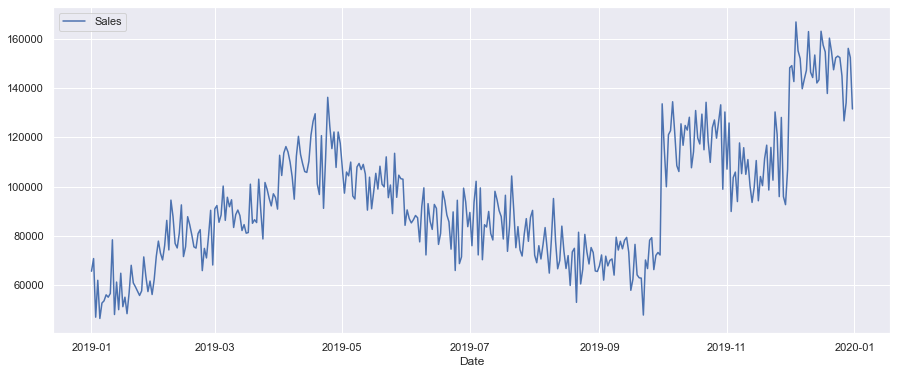

In [21]:
# Check the stationary of the dataset
df1.plot(figsize=(15, 6))
plt.show()

In [22]:
# Check stationary by using AIC
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [23]:
check_stationarity(df1.Sales)

The test statistic: -1.611278
p-value: 0.477305
Critical Values:
1%: -3.449
5%: -2.870
10%: -2.571


#### Stationary treatment

In [24]:
import numpy as np
ts_Sales_log = np.log(df1.Sales)
ts_Sales_log

Date
2019-01-01    11.092579
2019-01-02    11.167801
2019-01-03    10.758885
2019-01-04    11.035087
2019-01-05    10.747737
                ...    
2019-12-27    11.749009
2019-12-28    11.805711
2019-12-29    11.957769
2019-12-30    11.933738
2019-12-31    11.786415
Name: Sales, Length: 365, dtype: float64

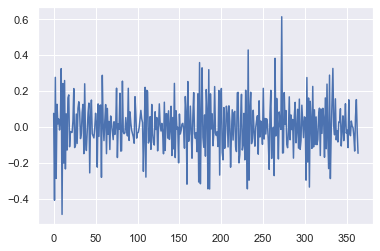

In [25]:
ts_Sales_log_diff = np.diff(ts_Sales_log)

plt.plot(ts_Sales_log_diff)

In [26]:
check_stationarity(ts_Sales_log_diff)

The test statistic: -14.483573
p-value: 0.000000
Critical Values:
1%: -3.449
5%: -2.870
10%: -2.571


#### Determine the value of p and q

In [27]:
# Using auto ARIMA to get get optimal p and q
import pmdarima as pm
auto_arima_fit = pm.auto_arima(df1.Sales, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=12,
                             seasonal=False,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7813.253, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7938.641, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7863.475, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7811.274, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7936.711, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7811.738, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7810.121, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7811.704, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7811.909, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7815.095, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7812.333, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7813.669, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7809.715, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7811.547, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [28]:
# Model fit
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(df1.Sales, order=(0, 1, 1))
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  365
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3902.774
Date:                Tue, 28 Jun 2022   AIC                           7809.548
Time:                        21:38:26   BIC                           7817.342
Sample:                    01-01-2019   HQIC                          7812.646
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6517      0.033    -19.571      0.000      -0.717      -0.586
sigma2      1.205e+08   2.36e-11    5.1e+18      0.000    1.21e+08    1.21e+08
Ljung-Box (L1) (Q):                   0.29   Jarque-

#### Residuals Diagnosis

<AxesSubplot:xlabel='Date'>

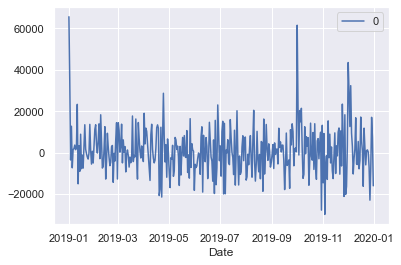

In [29]:
# Residual plot
residuals = pd.DataFrame(results.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

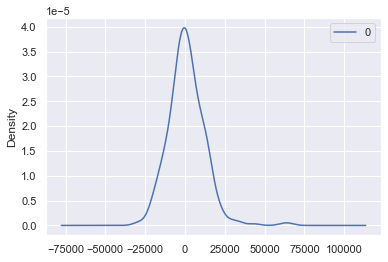

In [30]:
# Residual distribution
residuals.plot(kind='kde')

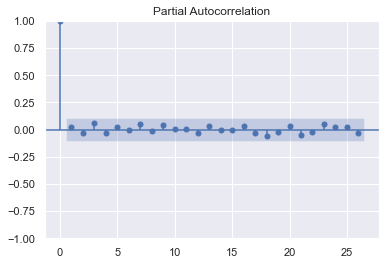

In [31]:
# pacf plot
plot_pacf(residuals)
print()

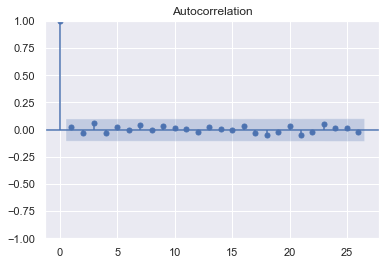

In [32]:
# acf plot
plot_acf(residuals)
print()

#### Prediction

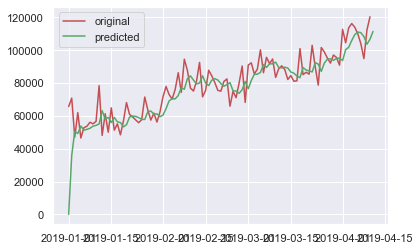

In [33]:
from math import sqrt
from sklearn.metrics import mean_squared_error

plt.plot(df1.Sales[:100],label = 'original', color='r' )
plt.plot(results.predict(0,100),label = 'predicted', color='g' )

plt.legend()

#### Forecasting

In [34]:
# Forecast the sales of the next 30 days
n=30
forecast = results.forecast(steps=n)
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='B'))
print(df_forecast)

                 forecast
2020-01-01  141902.108214
2020-01-02  141902.108214
2020-01-03  141902.108214
2020-01-06  141902.108214
2020-01-07  141902.108214
2020-01-08  141902.108214
2020-01-09  141902.108214
2020-01-10  141902.108214
2020-01-13  141902.108214
2020-01-14  141902.108214
2020-01-15  141902.108214
2020-01-16  141902.108214
2020-01-17  141902.108214
2020-01-20  141902.108214
2020-01-21  141902.108214
2020-01-22  141902.108214
2020-01-23  141902.108214
2020-01-24  141902.108214
2020-01-27  141902.108214
2020-01-28  141902.108214
2020-01-29  141902.108214
2020-01-30  141902.108214
2020-01-31            NaN
2020-02-03            NaN
2020-02-04            NaN
2020-02-05            NaN
2020-02-06            NaN
2020-02-07            NaN
2020-02-10            NaN
2020-02-11            NaN


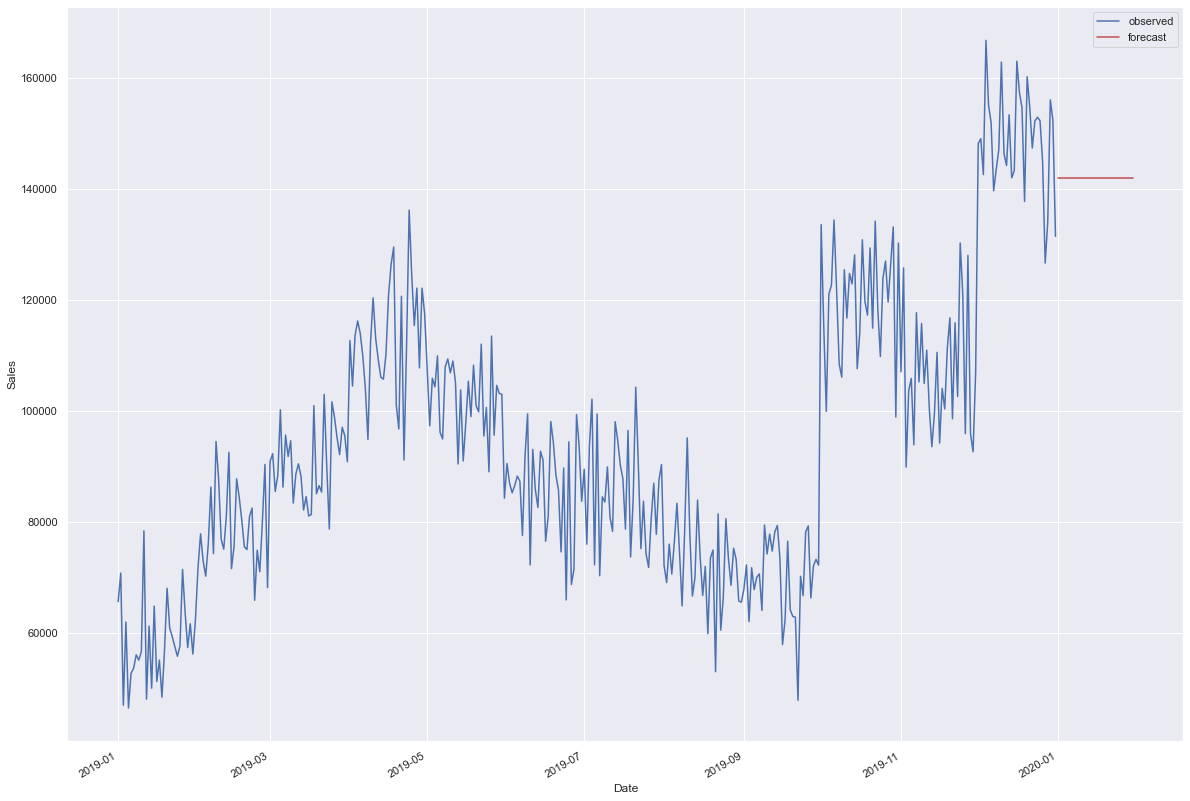

In [35]:
# Plot the real and predicted value in density curve
ci = df_forecast.values
ax = df1[:400].Sales.plot(label='observed', figsize=(20, 15))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,-1],
                ci[:,0], color='b', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

#### Evaluation 

In [36]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
rmse=rmse(df1.Sales, results.predict())
print("The rmse value is:",rmse) 

# Calculate mean squared error
mse = mean_squared_error(df1.Sales, results.predict())
print("The mse value is:",mse)

The rmse value is: 11496.478368552902
The mse value is: 132169014.8786048


The forecast is identical, because there is no pattern detected in the dataset, and the forecasting output was generated randomly. So manual adjustment is required to find a better model. https://stats.stackexchange.com/questions/333092/why-i-get-the-same-predict-value-in-arima-model#:~:text=This%20is%20also%20seen%20from,will%20generate%20same%20next%20value.

## Manul adjustment

#### Stationary treatment

In [37]:
# Two steps differencing
ts_Sales_log = np.log(df1.Sales)
ts_Sales_log

Date
2019-01-01    11.092579
2019-01-02    11.167801
2019-01-03    10.758885
2019-01-04    11.035087
2019-01-05    10.747737
                ...    
2019-12-27    11.749009
2019-12-28    11.805711
2019-12-29    11.957769
2019-12-30    11.933738
2019-12-31    11.786415
Name: Sales, Length: 365, dtype: float64

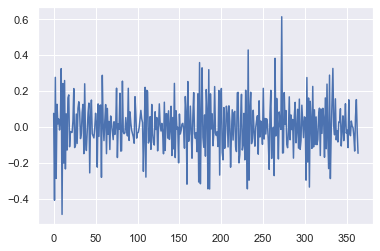

In [38]:
ts_Sales_log_diff = np.diff(ts_Sales_log)

plt.plot(ts_Sales_log_diff)

In [39]:
ts_Sales_log2 = np.log(ts_Sales_log)
ts_Sales_log2

Date
2019-01-01    2.406276
2019-01-02    2.413035
2019-01-03    2.375732
2019-01-04    2.401080
2019-01-05    2.374695
                ...   
2019-12-27    2.463769
2019-12-28    2.468583
2019-12-29    2.481381
2019-12-30    2.479369
2019-12-31    2.466948
Name: Sales, Length: 365, dtype: float64

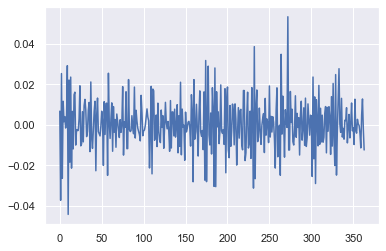

In [40]:
ts_Sales_log_diff2 = np.diff(ts_Sales_log2)

plt.plot(ts_Sales_log_diff2)

In [41]:
# Check stationary
check_stationarity(ts_Sales_log_diff2)

The test statistic: -14.528850
p-value: 0.000000
Critical Values:
1%: -3.449
5%: -2.870
10%: -2.571


#### Maualy determine (p,d,q)

In [42]:
# Try to use auto ARIMA to find p and q
import pmdarima as pm
auto_arima_fit = pm.auto_arima(ts_Sales_log_diff2, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=12,
                             seasonal=False,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2283.680, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2134.108, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2234.688, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2283.981, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2283.886, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2280.232, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2283.480, Time=0.26 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.469 seconds


However, the results of the model above is quite tricky. I have already performed 2 times differencing, so is the number of d should be 2

In [43]:
# Manualy set d =2 and q=1
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.arima.model import ARIMA
mod1 = ARIMA(df1.Sales, order=(0, 2, 1))
results1 = mod1.fit()
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  365
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -3966.006
Date:                Tue, 28 Jun 2022   AIC                           7936.012
Time:                        21:38:31   BIC                           7943.800
Sample:                    01-01-2019   HQIC                          7939.108
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9982      0.053    -19.004      0.000      -1.101      -0.895
sigma2      2.063e+08   1.55e-10   1.33e+18      0.000    2.06e+08    2.06e+08
Ljung-Box (L1) (Q):                  68.72   Jarque-

#### Residual Diagnosis

<AxesSubplot:xlabel='Date'>

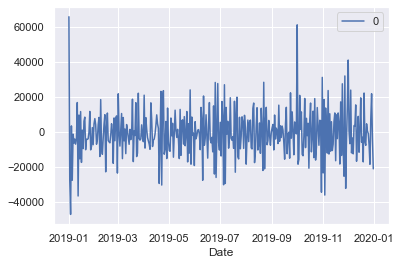

In [44]:
residuals1 = pd.DataFrame(results1.resid)
residuals1.plot()

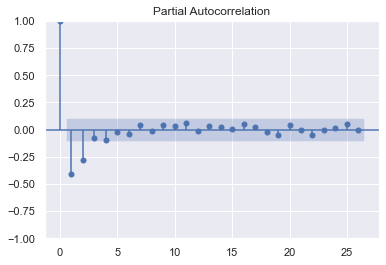

In [45]:
plot_pacf(residuals1)
print()

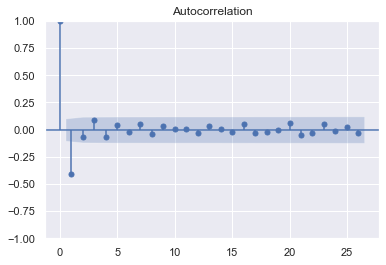

In [46]:
plot_acf(residuals1)
print()

#### Prediction

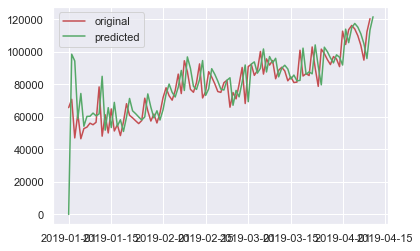

In [47]:
from math import sqrt
from sklearn.metrics import mean_squared_error

plt.plot(df1.Sales[:100],label = 'original', color='r' )
plt.plot(results1.predict(0,100),label = 'predicted', color='g' )

plt.legend()

#### Forecasting

In [48]:
# Forecast the sales of the next 30 days
n=30
forecast = results1.forecast(steps=n)
df_forecast1 = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='B'))
print(df_forecast1)

                 forecast
2020-01-01  131804.429744
2020-01-02  132154.559489
2020-01-03  132504.689233
2020-01-06  133555.078467
2020-01-07  133905.208211
2020-01-08  134255.337956
2020-01-09  134605.467700
2020-01-10  134955.597445
2020-01-13  136005.986678
2020-01-14  136356.116423
2020-01-15  136706.246167
2020-01-16  137056.375912
2020-01-17  137406.505656
2020-01-20  138456.894890
2020-01-21  138807.024634
2020-01-22  139157.154378
2020-01-23  139507.284123
2020-01-24  139857.413867
2020-01-27  140907.803101
2020-01-28  141257.932845
2020-01-29  141608.062590
2020-01-30  141958.192334
2020-01-31            NaN
2020-02-03            NaN
2020-02-04            NaN
2020-02-05            NaN
2020-02-06            NaN
2020-02-07            NaN
2020-02-10            NaN
2020-02-11            NaN


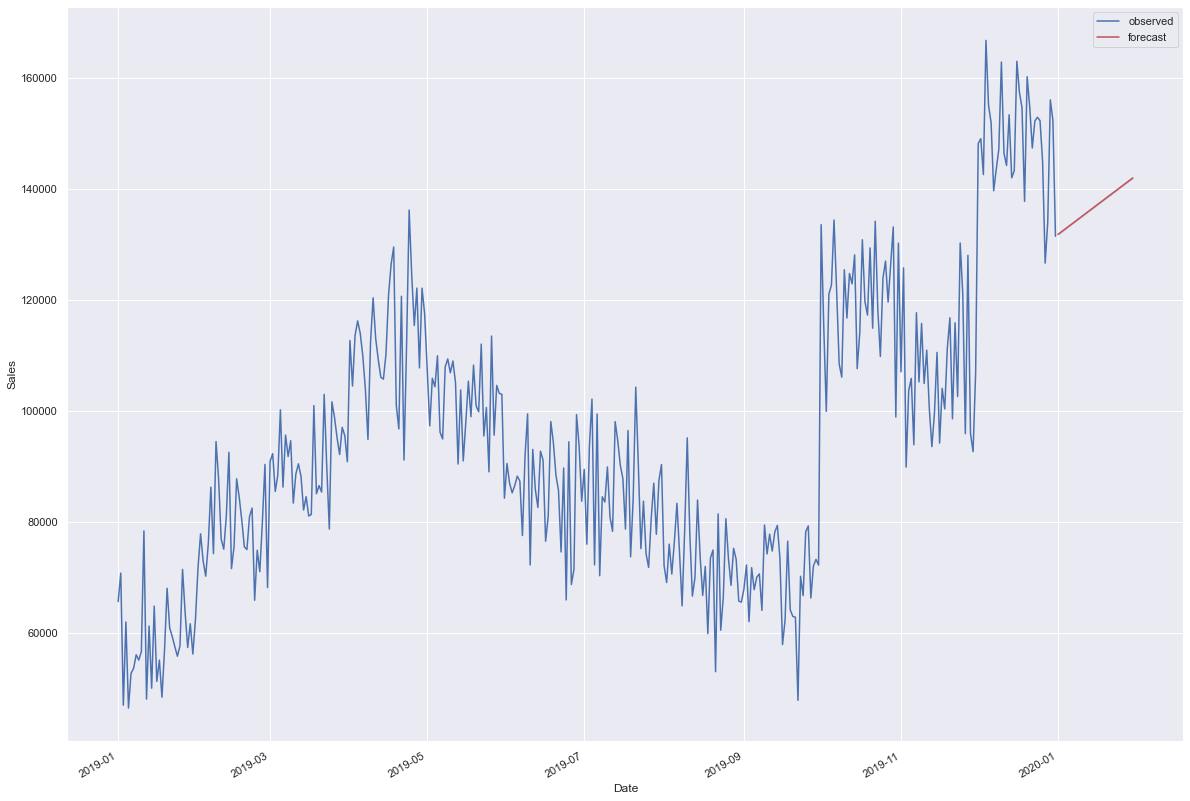

In [49]:
# PLot the observed and forecasting value
ci2 = df_forecast1.values
ax2 = df1[:400].Sales.plot(label='observed', figsize=(20, 15))
df_forecast1.plot(ax=ax2,label='Forecast',color='r')
ax2.fill_between(df_forecast1.index,
                ci2[:,-1],
                ci2[:,0], color='b', alpha=.25)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')

plt.legend()
plt.show()

#### Evaluation

In [50]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
rmse=rmse(df1.Sales, results1.predict())
print("The rmse value is:",rmse) 

# Calculate mean squared error
mse = mean_squared_error(df1.Sales, results1.predict())
print("The mse value is:",mse)

The rmse value is: 13890.190028442816
The mse value is: 192937379.0262522


# Time Series Analysis-Machine Learning

In [52]:
# Extract values from df1
values = df1.values

#### Define related functions

In [53]:
# Transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [54]:
# Split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [55]:
# Fit an xgboost model and make a one step forecasting
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=8000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [56]:
# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

#### Data transformation and evaluation

In [57]:
# Transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
data

array([[ 65681.94,  70813.2 ,  47046.2 , ...,  46524.63,  52777.49,
         53676.42],
       [ 70813.2 ,  47046.2 ,  62012.21, ...,  52777.49,  53676.42,
         56112.47],
       [ 47046.2 ,  62012.21,  46524.63, ...,  53676.42,  56112.47,
         55153.13],
       ...,
       [152214.45, 152888.82, 152268.42, ..., 126628.05, 134015.5 ,
        156024.62],
       [152888.82, 152268.42, 144912.02, ..., 134015.5 , 156024.62,
        152319.81],
       [152268.42, 144912.02, 126628.05, ..., 156024.62, 152319.81,
        131454.3 ]])

>expected=144195.1, predicted=150891.0
>expected=153332.1, predicted=141653.0
>expected=141991.8, predicted=149190.8
>expected=143269.7, predicted=153828.3
>expected=162970.6, predicted=161026.1
>expected=157364.7, predicted=149048.8
>expected=154598.8, predicted=144804.5
>expected=137732.7, predicted=145574.8
>expected=160181.3, predicted=136225.8
>expected=154756.9, predicted=146753.7
>expected=147348.1, predicted=157223.5
>expected=152214.5, predicted=150409.6
>expected=152888.8, predicted=150345.8
>expected=152268.4, predicted=144777.5
>expected=144912.0, predicted=155159.5
>expected=126628.1, predicted=145952.0
>expected=134015.5, predicted=119720.9
>expected=156024.6, predicted=124322.3
>expected=152319.8, predicted=146953.6
>expected=131454.3, predicted=147289.9
RMSE: 10723.614


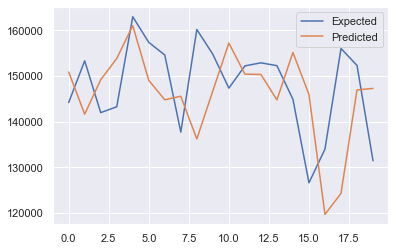

In [59]:
# Evaluate
rmse, y, yhat = walk_forward_validation(data, 20)
print('RMSE: %.3f' % rmse)

# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

#### Prediction

In [60]:
# Build prediction model
preds = []
for i in range(30):
    # transform the time series data into supervised learning
    train = series_to_supervised(values, n_in=6)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=8000)
    model.fit(trainX, trainy)
    # construct an input for a new preduction
    row = values[-6:].flatten()
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    print('Input: %s, Forecast: %.3f' % (row, yhat[0]))
    values = np.append(values, yhat)
    preds.append(yhat)

Input: [144912.02 126628.05 134015.5  156024.62 152319.81 131454.3 ], Forecast: 134709.172
Input: [126628.05     134015.5      156024.62     152319.81     131454.3
 134709.171875], Forecast: 153257.953
Input: [134015.5      156024.62     152319.81     131454.3      134709.171875
 153257.953125], Forecast: 151456.578
Input: [156024.62     152319.81     131454.3      134709.171875 153257.953125
 151456.578125], Forecast: 134615.000
Input: [152319.81     131454.3      134709.171875 153257.953125 151456.578125
 134615.      ], Forecast: 147188.359
Input: [131454.3      134709.171875 153257.953125 151456.578125 134615.
 147188.359375], Forecast: 154955.234
Input: [134709.171875 153257.953125 151456.578125 134615.       147188.359375
 154955.234375], Forecast: 151819.766
Input: [153257.953125 151456.578125 134615.       147188.359375 154955.234375
 151819.765625], Forecast: 144186.797
Input: [151456.578125 134615.       147188.359375 154955.234375 151819.765625
 144186.796875], Forecast: 147

In [61]:
# Predict the sales of next 30 days
df_preds = pd.DataFrame({'forecast':preds},index=pd.date_range(start='1/1/2020', periods=30, freq='B'))
df_preds.head()

,forecast
2020-01-01,[134709.17]
2020-01-02,[153257.95]
2020-01-03,[151456.58]
2020-01-06,[134615.0]
2020-01-07,[147188.36]


In [62]:
df_preds.dtypes

forecast    object
dtype: object

In [63]:
# Change datatype for proceeding
df_preds['forecast'] = df_preds['forecast'].astype('float')

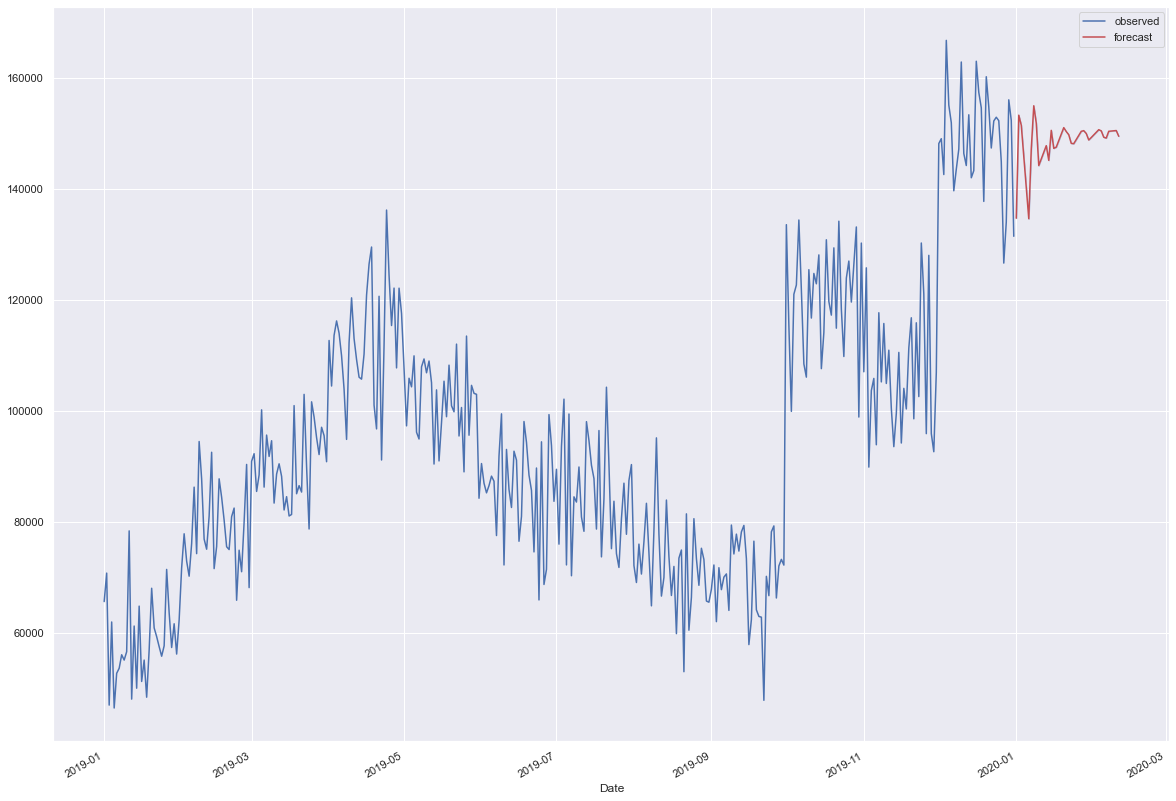

In [64]:
# Plot the predicted and actual sales
ci1 = df_preds.values
ax1 = df1[:400].Sales.plot(label='observed', figsize=(20, 15))
df_preds.plot(ax=ax1,label='Forecast',color='r')
ax1.fill_between(df_forecast.index,
                ci1[:,-1],
                ci1[:,0], color='b', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()